In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import katdal
import dask 

In [2]:
def readfile(path2file):
    # Rest the data
    #data.select(reset='TFB')
    
    # Loading the data
    data = katdal.open(path2file)
    all_Time = data.timestamps
    data.select(scans='track')
    track_Time = data.timestamps
    
    # Getting timestamps indices of track scan only
    idx_track = []
    for i,t in enumerate(all_Time):
        if t in list(track_Time):
            idx_track.append(i)
    
  
            
    return data,idx_track    

In [41]:
def get_weights(data,idx_track):
    # Getting the weights
    store = data.source.data.store
    chunk_info = data.source.telstate['chunk_info']
    array = 'weights'
    info = chunk_info[array]
    array_name = store.join(info['prefix'], array)
    darray = store.get_dask_array(array_name, info['chunks'], info['dtype'])
    weights = darray[:, :, :].compute()[idx_track].astype(np.int32)   # time, freq, baseline selection
    sdp_dumpRate= data.dump_period
    cbf_dumpRate = data.source.metadata.attrs['i0_baseline_correlation_products_int_time']
    
    data.select(flags='ingest_rfi') # this chooses only the ingest flags
    IngestFlags = data.flags # all tracks ingest flags
    
    return IngestFlags, weights, sdp_dumpRate, cbf_dumpRate

In [39]:
def stats_of_ingest(IngestFlags, weights, sdp_dumpRate, cbf_dumpRate):
    # Percentage of data Excised by the Ingest
    
    NoSample = np.rint(sdp_dumpRate/cbf_dumpRate) # Maximum number of CBF samples that forms
                                                               # one SDP sample
        
    # Number of sample excised per each SDP visibility
    NoSampleExcised = np.sum(np.rint((255-weights)/64.))
    
    # Perentage of CBF samples excised by the ingest
    PercentageIngestExcised = (NoSampleExcised/(NoSample*weights.size))*100
   
    #Number of Samples that are Weighted 255 AND Ingest_flag was 1: 
    N_rfi255 = np.where((np.ravel(weights) == 255) & (np.ravel(IngestFlags)==True))
    
    #Number of Samples that were Weighted 255 AND Ingest_flag was 0:
    N_pure255 =  np.where((np.ravel(weights) == 255) & (np.ravel(IngestFlags)==False))
    # Percentage of clean samples when no excsiion of CBF samples
    pclean_CBF = (float(N_pure255[0].size)/weights.size)*100
    
    #Number of Samples that were Weighted 255 AND Ingest_flag was 1:
    N_rfi255 =  np.where((np.ravel(weights) == 255) & (np.ravel(IngestFlags)==True))
    # Percentage of RFI samples when no excision of CBF samples.
    prfi_CBF = (float(N_rfi255[0].size)/weights.size)*100
    
    
    # Percentage of SDP samples that had RFI excised
    p_sdp_excised = 100 - (pclean_CBF+prfi_CBF )
    return pclean_CBF, prfi_CBF, PercentageIngestExcised , p_sdp_excised
    

In [5]:
data, idx_track = readfile('/scratch2/isaac/rfi_data/goodfiles/1540742104_sdp_l0.full.rdb')

In [42]:
IngestFlags, weights, sdp_dumpRate, cbf_dumpRate = get_weights(data, idx_track)

In [43]:
pclean_CBF, prfi_CBF, PercentageIngestExcised, p_sdp_excised = stats_of_ingest(IngestFlags, weights, sdp_dumpRate, cbf_dumpRate)

# Explanation

RFI detection is carried out during the ingest step by detecting outliers along the frequency axis in each individual correlator dump (time). We will refer to this RFI as ingest_rfi now on. This process will normally detect the very strong RFI. At this stage where averaging is carried out, samples which are detected as RFI are excised, only unflagged samples are averaged to 2, 4 or 8 s and further used in the data processing pipeline. The output of ingest step is therefore an averaged RFI excised dataset with  pertinent meta-data stored in telestate. The output of the ingest will be called the SDP visibility sample now on.<br >

To account for data loss due to the ingest excision each visibility data point has an associated weight $W_{SDP}$ which tells us how many samples were averaged to produce these visibilities.<br >

Let us define N as number of correlator samples, $V_{CBF}$ as the visibility sample from the correlator beam former (CBF), U as the set of indices of unflagged correlator visibilities and $V_{SDP}$ as the SDP visibility sample.<br >


The ingest flags becomes TRUE when all N samples are flagged as RFI by the ingest, then at this point there is no excision of data. Then, the SDP visibility sample can be calculated as follows:

\begin{eqnarray}
V_{SDP} = W_{SDP} \sum_i V_{CBF[i]}
\end{eqnarray}

where,
\begin{eqnarray}
W_{SDP} =  \frac{1}{N}
\end{eqnarray}


with partial flagging or excision of data the ingest flags becomes *FALSE* then the SDP visibility becomes,

\begin{eqnarray}
V_{SDP} = W_{SDP} \sum_{i \in U} V_{CBF[i]}
\end{eqnarray}

and,
\begin{eqnarray}
W =  \frac{1}{N_{U}}
\end{eqnarray}


with $N_U$ being defined as the number of unflagged samples by the ingest.
The set of weights are as follows: **{64, 127, 170, 191, 255}**

- 64 - 3 out of 4 samples have been excised
- 127 - 2 out of 4 samples has been excised
- 170 & 191 - 1 out of 4 samples has been excised
- If 255 - NO samples were excised (ALL samples were present)


If the weight is 255 it means there was no excision on the ingest step, so this implies that either all the samples were detected as RFI by the ingest or all the samples were non RFI.

### Looking at data with weight 255 : All CBF samples were present

- Weight 255 and ingest RFI flags is  0

In [44]:
print 'Percentage of CBF samples with no excision and no RFI : ',pclean_CBF

Percentage of CBF samples with no excision and no RFI :  95.0272678275


- Weight 255 and ingest flag is 1

In [45]:
print 'Percentage of CBF samples with no excision and with RFI : ' ,prfi_CBF

Percentage of CBF samples with no excision and with RFI :  1.77626070192


The number of CBF samples excised by the ingest can be calculated as follows:

\begin{eqnarray}
No\_excised\_samples = \frac{\sum_i (255 - w_i)}{64}
\end{eqnarray}

where $w_i$ is the SDP wight associated to each visibility. <br >

Thus we can compute the fraction of CBF samples excised by the ingest as follows:
\begin{eqnarray}
CBF\_excised =\frac{\frac{\sum_i (255 - w_i)}{64}}{Number\_of\_CBF\_samples}
\end{eqnarray}

In [46]:
print 'Percentage of CBF samples that have been excised',PercentageIngestExcised  

Percentage of CBF samples that have been excised 1.339354473227084


### Looking at the data with weight < 255. SDP samples that had RFI excised.

- Weight < 255

In [47]:
 print 'Percentage of SDP samples that had RFI excised',  p_sdp_excised

Percentage of SDP samples that had RFI excised 3.1964714706


In [48]:
N_pure255 =  np.where((np.ravel(weights) == 255) & (np.ravel(IngestFlags)==False))

In [49]:
weights = weights.ravel()

In [51]:
weights[N_pure255[0]] = 500

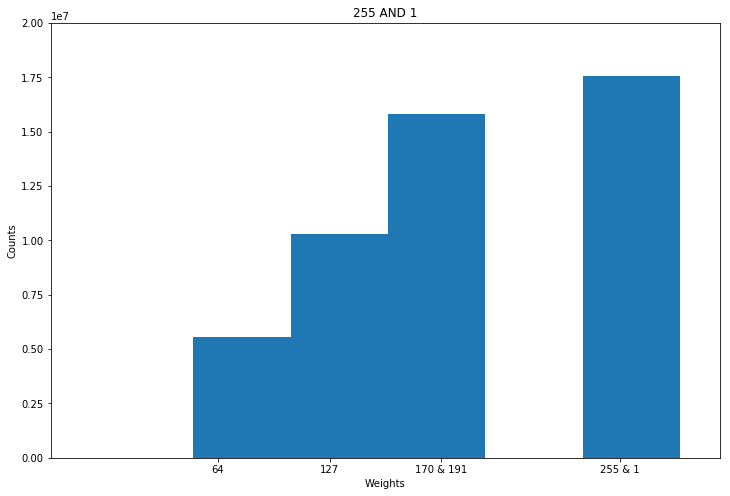

In [63]:
plt.figure(figsize=(12,8))
plt.title('255 AND 1')
plt.xlim(0,300)
plt.ylim(0,2e7)
plt.xlabel('Weights')
plt.ylabel('Counts')
plt.hist(weights)
plt.xticks([75,125,175,255],['64','127','170 & 191','255 & 1'])
plt.show()

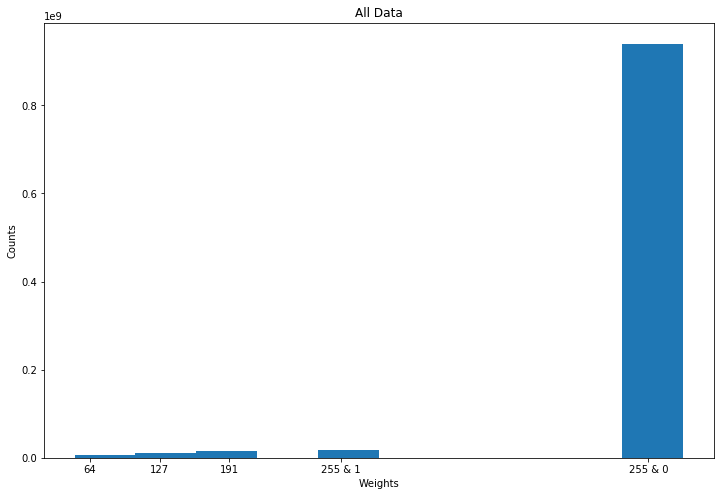

In [62]:
plt.figure(figsize=(12,8))
plt.title('All Data')
#plt.xlim(0,300)
#plt.ylim(0,2e7)
plt.xlabel('Weights')
plt.ylabel('Counts')
plt.hist(weights)
plt.xticks([75,125,175,255,475],['64','127','191','255 & 1','255 & 0'])
plt.show()